<h1>Outline<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Estimating-recombination-rate-landscapes-with-recurrent-neural-networks" data-toc-modified-id="Estimating-recombination-rate-landscapes-with-recurrent-neural-networks-1">Estimating recombination rate landscapes with recurrent neural networks</a></span></li><li><span><a href="#Recombination---how-it's-estimated" data-toc-modified-id="Recombination---how-it's-estimated-2">Recombination - how it's estimated</a></span></li><li><span><a href="#Review-of-current-methods" data-toc-modified-id="Review-of-current-methods-3">Review of current methods</a></span></li><li><span><a href="#Deep-learning-approaches" data-toc-modified-id="Deep-learning-approaches-4">Deep learning approaches</a></span></li><li><span><a href="#ReLERNN-outline" data-toc-modified-id="ReLERNN-outline-5">ReLERNN outline</a></span></li><li><span><a href="#Simulating-data-sets" data-toc-modified-id="Simulating-data-sets-6">Simulating data sets</a></span></li><li><span><a href="#msprime---simulating-genealogies" data-toc-modified-id="msprime---simulating-genealogies-7">msprime - simulating genealogies</a></span></li><li><span><a href="#msprime---adding-recombination" data-toc-modified-id="msprime---adding-recombination-8">msprime - adding recombination</a></span></li><li><span><a href="#tskit-tables---a-succinct-representation-of-data" data-toc-modified-id="tskit-tables---a-succinct-representation-of-data-9">tskit tables - a succinct representation of data</a></span></li><li><span><a href="#msprime---adding-mutations" data-toc-modified-id="msprime---adding-mutations-10">msprime - adding mutations</a></span></li><li><span><a href="#Combining-recombination-and-mutation" data-toc-modified-id="Combining-recombination-and-mutation-11">Combining recombination and mutation</a></span></li></ul></div>

In [3]:
%reload_ext autoreload
%autoreload 2
%config InlineBackend.figure_format ='retina'

import utils

## Introduction

There will be a short (15-20 min) mini-lecture to introduce the problem. It will go along the following lines:

1. Recombination - what it is 
   - Morgan's illustration:
   <img src="https://upload.wikimedia.org/wikipedia/commons/thumb/0/0e/Morgan_crossover_1.jpg/440px-Morgan_crossover_1.jpg"></img>
   - some facts:
     - when (meioses)
     - how many (>=1 per chromosome?)
1. Recombination - why it's important (cf recent special issue in Royal Society? and Booker paper)
    - Booker: rate correlated with magnitude of F_ST and other estimators which confounds analyses of significance
    - haplotype estimation: crucial to determine signals of selection (cf tsinfer, Relate)
    - demographic inference (?)
    - Royal society issue: https://royalsocietypublishing.org/toc/rstb/2017/372/1736
2. Recombination - how to estimate (Penalba & Wolf paper)
    1. Pedigree-based analyses (time-, lab-consuming)
    2. Gamete-based approach (sperm typing)
    3. Population-based (only method of practical use for natural populations)
3. Review of current methods (LDHelmet, iSMC, ...)
4. Describe ReLERNN

Theory will be followed by a review of the lab, in which the students will simulate data and gradually build a network step by step.

1. describe msprime and how it will be used to simulate observed and training/test data
   - see mini-introduction below; use similar examples in lecture
2. describe stdpopsim which is used to simulate standard published population genetic models
   - use examples from introduction below
3. describe the network that we are going to build, with some info left out (for students to fill in)
   - describe the ReLERNN network and how we are going to build step by step

# Estimating recombination rate landscapes with recurrent neural networks

## Recombination - what it is

Recombination:

- breaking and repair of DNA strands
- produces new combinations of alleles
- here focus on *meiotic recombination*

Pros: improved adaptation

Cons: break association between beneficial alleles


#### Estimates of recombination rate

Expressed as **recombination frequency** per mega- or kilobase per generation (e.g. cM/Mb)

**centiMorgan (cM)**: distance between chromosomal positions such that 0.01 crossovers expected per generation

<div><img src="https://upload.wikimedia.org/wikipedia/commons/thumb/0/0e/Morgan_crossover_1.jpg/440px-Morgan_crossover_1.jpg" width="800px"></img><small><cite data-cite="482049/BM3UHY2D"></cite> </small></div>

https://en.wikipedia.org/wiki/Genetic_recombination

> In eukaryotes, recombination during meiosis is facilitated by chromosomal crossover.
The crossover process leads to offspring having different combinations of genes from those 
of their parents, and can occasionally produce new chimeric alleles. The shuffling of genes
brought about by genetic recombination produces increased genetic variation



Genetic linkage is measured in centiMorgan, or map units, and is defined as above (source: https://en.wikipedia.org/wiki/Centimorgan)

Also (https://en.wikipedia.org/wiki/Genetic_linkage#Recombination_frequency):

> Recombination frequency (θ) is the frequency with which a single chromosomal crossover will take place between two genes during meiosis. A centimorgan (cM) is a unit that describes a recombination frequency of 1%.

estimates of recombination rate are commonly expressed as the recombination frequency per mega- or kilobase per generation <cite data-cite="482049/X9HA5BKN"></cite>

NB: distance in centimorgans does **not** correspond exactly to the probability of genetic recombination

## Recombination - why it's important

Historically mainly studied in context of the evolution of sex

Recombination rate variation, its evolution and its effect on evolutionary processes less studied

Recently getting more attention: cf Theme issue ‘Evolutionary causes and consequences of recombination rate variation in sexual organisms' in Philosophical Transactions of the Royal Society B (biological sciences) <cite data-cite="482049/UMM2EVLZ"></cite>


### Recombination rate varies between species


<table><tr>
<td> <img src="https://oup.silverchair-cdn.com/oup/backfile/Content_public/Journal/mbe/23/2/10.1093_molbev_msj050/2/molbiolevolmsj050f02_lw.jpeg?Expires=1608836647&Signature=TAipqp-QEEc~le~5JKdbyul4ph8QTJKLRWxA37edv36VdOg1pSjgEIkvXj~XaCyOM~9JQBUJwmq1EQkks3WK0lzBHpzbIQkTzrNYB~Fi7nFg7OyseTcKb7-IPkq7IbvpqEM4FQVcPKXJ9Kb3W8pcG8FLByiwSEURPxK7tgXVGVTjPQ9f0bftr89CSI41szv5JYm9HXhd2RsPWhftW6nOsaxaLQPex8JZIaFrD6eH6uTufjIhG0XsuTWFSloYCcyHVIf1u0gSb7z9SpN0cBjoPzlTRaIGJZd-AT7xN~a1OrziiY5JnFYXMPPlSUSr29gKw8G3ZXVgDzOEaKMdJ0SiKA__&Key-Pair-Id=APKAIE5G5CRDK6RD3PGA" alt="Lynch" style="width: 500px;"/> </td>
<td> <img src="https://royalsocietypublishing.org/cms/asset/3819b484-ada1-42b0-b26c-9dd70c374f59/rstb20160455f02.jpg" alt="Stapley" style="width: 500px;"/> </td>
</tr>
<tr>
    <td>
        <small><cite data-cite="482049/CFAHN7KS"></cite></small>
    </td>
    <td>
        <small><cite data-cite="482049/X9HA5BKN"></cite></small> 
    </td>
  </tr>
</table>

### Recombination rate varies within genomes

<table>
    <tr>
    <td>
    <img src="https://journals.plos.org/plosgenetics/article/figure/image?size=large&id=10.1371/journal.pgen.1002905.g001" width=400></img>
    </td>       <td>
            <img src="https://www-annualreviews-org.ezproxy.its.uu.se/na101/home/literatum/publisher/ar/journals/content/genet/2014/genet.2014.48.issue-1/annurev-genet-120213-092525/20141110/images/medium/ge480383.f1.gif" width=200 style="margin-left: auto margin-right: auto"></img>
    </td>
    </tr>
    <tr>
    <td>
        <small><cite data-cite="482049/WWMIEP3G"></cite></small>
    </td>
        <td>
            <small><cite data-cite="482049/C622SYAA"></cite></small>
        </td>
    </tr>
</table>

## Highlight recombination rate variation:


### Between species 

Reasons <cite data-cite="482049/CFAHN7KS"></cite>:

> The magnitude of recombination per physical distance scales negatively with genome size, ranging from 3 × 10−10/bp/generation in Pinus sylvestris to 3 × 10−6/bp/generation in Saccharomyces cerevisiae (fig. 2). Such scaling is due mostly to the simple fact that most species experience between one and two meiotic crossover events per chromosome


Plots are based on population recombination parameter \rho


### Within genome (<cite data-cite="482049/C622SYAA"></cite>)





### Recombination landscapes and genome architecture

<div><img src="https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4617962/bin/1656f01.jpg" width=400></img><small><cite data-cite="482049/M6IAUADD"></cite></small></div>

Burri paper early in empirically showing the relationship between recombination landscapes and genomic landscapes:

> Contrary to expectations from models that interpret differentiation islands as genomic regions involved in reproductive isolation that are shielded from gene flow, patterns of sequence divergence (dxy and relative node depth) do not support a major role of gene flow in the evolution of the differentiation landscape in these species. Instead, as predicted by models of linked selection, genome-wide variation in diversity and differentiation can be explained by variation in recombination rate and the density of targets for selection. We thus conclude that the heterogeneous landscape of differentiation in Ficedula flycatchers evolves mainly as the result of background selection and selective sweeps in genomic regions of low recombination. Our results emphasize the necessity of incorporating linked selection as a null model to identify genome regions involved in adaptation and speciation.

In particular emphasize the dependency between recombinatio rate and genetic diversity, and also magnitude of test statistics, especially F_ST: segway to next slide, results from Booker

Note that here we assume (I think) that the dependency of F_ST on r is due to non-neutrality

## Variation in recombination rate affects detection of outliers in genome scans under neutrality

<div><img src="https://onlinelibrary.wiley.com/cms/asset/a0f63d0a-7ca9-4a9f-9508-c5a526e0d15e/mec15690-fig-0002-m.png"></img><small> <cite data-cite="482049/CNQJSTBL"></cite> </small></div>

<div>

<small> <cite data-cite="482049/HEW99NTB"></cite> </small>
    </div>

Purely theoretical study: simulated data with msprime 

(rephrase): Consequence: underpowered in low-recombination areas, increased risk of identifying false-positive regions of differentiation

Booker et al:

- showed that this dependency even exists for **neutrally** evolving genomes

# Recombination - how it's estimated

Segway: there's a reason there has been few studies of recombination rate variation, in particular in natural populations: it is difficult to measure/estimate and pedigrees are usually not available

estimates of recombination rate are commonly expressed as the recombination frequency per mega- or kilobase per generation <cite data-cite="482049/X9HA5BKN"></cite>

Here briefly review Penalba Wolf, focus on natural populations and molecular methods

# Review of current methods

## Hudson's method

## LDHelmet

## iSMC

# Deep learning approaches

## Convolutional neural networks (CNNs)

cf Schrider et al

## ReLERNN (RNN)

cf Adrion et al

# ReLERNN outline

Describe different stages:

1. observational data is used to estimate parameters for simulation (should mention that this can be provided, e.g. via stairway plots for demographics, mutation rate, ...)
2. simulate training/test/validation data
3. train network
4. predict on observed data
5. bootstrap results (how is this done?)

# Simulating data sets

short outline of what we want together with a coalescent tree description. Introduce msprime and stdpopsim

## Observed data

The observed data consists of genome alignments of DNA sequences from a sample of individuals. Actually we represent the input as **genotype** alignments since monomorphic sites are non-informative, together with **positions** such that we know the distance between the variants.

Will probably need to describe haplotype blocks and genetic background here, or above in the introduction of recombination (better!)

## Desired outcome - DNA sequences

We want to simulate observations as DNA sequences that share a **common history**. The simulation should also introduce **variation**, or mutations, and **recombination**, that has the effect of shuffling variants to different surroundings.

Illustrate a set of sequences here

Simulation results will depend on the following parameters:

- mutation rate: the higher the rate, the more mutations 
- recombination rate: higher rate means haplotypes are shorter, or that mutations are shuffled to different backgrounds at a higher rate
- demographic history: bottlenecks will affect the shape of genealogies and thus the population sizes at different timepoints, which in turn affects the "size" upon which mutation and recombination can work

# msprime - simulating genealogies

Coalescent simulations create genealogies on which random mutations are sprinkled to introduce sequence variation. To begin with, we show the simplest command for simulating a small sample (n=6) of 1kb sequences from a population with a diploid effective population size 1000 ($N_e$=1000) and printing a genealogy:

In [1]:
import msprime
tree_sequence = msprime.simulate(sample_size=6, Ne=1000, length=1e4, random_seed=46)
tree = tree_sequence.first()
print(tree.draw(format="unicode"))

      10   
    ┏━━┻━━┓
    9     ┃
 ┏━━┻━┓   ┃
 ┃    8   ┃
 ┃   ┏┻━┓ ┃
 7   ┃  ┃ ┃
┏┻┓  ┃  ┃ ┃
┃ ┃  6  ┃ ┃
┃ ┃ ┏┻┓ ┃ ┃
0 5 1 4 3 2



The tree_sequence object is a succinct data structure (compact) representation of trees along the sequence, based on the fact that neighbouring genomic regions have correlated genealogical histories. Since we have no recombination events, there should only be one tree:

In [2]:
len(list(tree_sequence.trees()))

1

# msprime - adding recombination

Recombination events are added via the `recombination_rate` parameter:

In [4]:
tree_sequence = msprime.simulate(sample_size=6, Ne=1000, length=1e4, random_seed=46, recombination_rate=2e-8)
len(list(tree_sequence.trees()))

4

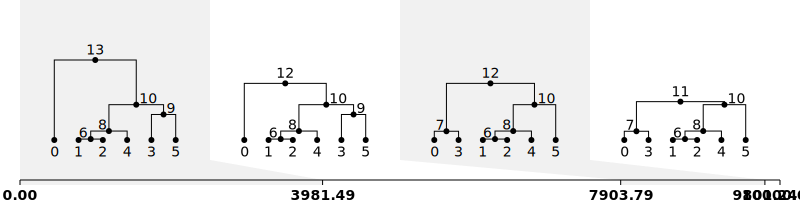

In [5]:
from IPython.core.display import SVG
display(SVG(tree_sequence.draw_svg()))

If we could infer genealogies along a sequence, we could also infer the recombination break points. However, in order to infer genealogies, we need sequence variation, or mutations.

# tskit tables - a succinct representation of data

In [10]:
tree_sequence.tables.asdict()

{'encoding_version': (1, 1),
 'sequence_length': 10000.0,
 'metadata_schema': '',
 'metadata': b'',
 'individuals': {'flags': array([], dtype=uint32),
  'location': array([], dtype=float64),
  'location_offset': array([0], dtype=uint32),
  'metadata': array([], dtype=int8),
  'metadata_offset': array([0], dtype=uint32),
  'metadata_schema': ''},
 'nodes': {'time': array([   0.        ,    0.        ,    0.        ,    0.        ,
            0.        ,    0.        ,   39.79588535,  376.27395602,
          385.03621643, 1098.0205148 , 1519.76635221, 1650.12234676,
         2436.83831592, 3442.37249724]),
  'flags': array([1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0], dtype=uint32),
  'population': array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=int32),
  'individual': array([-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1],
        dtype=int32),
  'metadata': array([], dtype=int8),
  'metadata_offset': array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=uint32),
  '

# msprime - adding mutations

In [15]:
tree_sequence = msprime.simulate(sample_size=6, Ne=1000, length=1e5, random_seed=46, mutation_rate=1e-8)
tree = tree_sequence.first()
for site in tree.sites():
    for mutation in site.mutations:
        print("Mutation @ position {:.2f} over node {}".format(site.position, mutation.node))

Mutation @ position 9684.21 over node 2
Mutation @ position 15035.89 over node 7
Mutation @ position 17880.71 over node 2
Mutation @ position 23925.52 over node 8
Mutation @ position 29009.12 over node 6
Mutation @ position 42881.62 over node 2
Mutation @ position 45500.39 over node 4
Mutation @ position 45876.04 over node 2
Mutation @ position 55598.08 over node 8
Mutation @ position 65918.72 over node 7
Mutation @ position 85216.19 over node 2
Mutation @ position 86713.84 over node 8
Mutation @ position 91784.93 over node 7


We can illustrate where the mutations occur by plotting the tree in svg format:

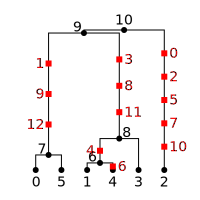

In [16]:
display(SVG(tree.draw_svg()))

# Combining recombination and mutation

## References
<small>
<div class="cite2c-biblio"></div>
    </small>